# Rental price predictor App
A tool for investors and prospective tenants to get a predicted weekly rental income for a property.

**The best model was a keras deep learning model with performance:**
- R-squared: 0.617525134254481
- Mean Absolute Error: 119.8287090433055

This is not a very rodust and powerfull model. A major challenge for this problem was scourcing usefull data, we had to proceed with the best we had and as a result we can only infer limited insights into this problem. Initialy we had banked on using the trademe api. We were able to create a trademe sandbox account and successfuly query rental listings in this test enviroment. Unfortunalty our request to access the live site was denied, leaving us with limited ways to source data. At this point where sourcing data was becoming the main obsticle and there had been several failed attempts, we should have switched to another problem.

Based on our model and the analysis of the data we have available we are going to assert that this model/app is best used to predict rental prices below $1400.

Note: Cells need to be run sequentially.

### Demo of app

In [170]:
video_url = "media/appTest.mp4" 

HTML("""<video width="800" controls><source src="{0}" type="video/mp4">Your browser does not support the video tag.</video>
""".format(video_url))

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.spatial import distance
from numpy.linalg import inv
from sklearn.cluster import DBSCAN
from joblib import dump, load
import shap

import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

all_data = pd.read_csv('data/prediction.csv')

## EDA

In [203]:
HOUSE_COLUMNS = ['Suburb','Price','Bedroom','Bathroom','Garage','Furniture','Type_Apartment','Type_Carpark',
 'Type_House','Type_Studio','Type_Townhouse','Type_Unit','Type_Unknown']

In [204]:
data = all_data[HOUSE_COLUMNS].copy()
data['Garage'] = data['Garage'].fillna(0)

data['Suburb'] = data['Suburb'].astype(str)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

unique_values = data['Suburb'].unique()
category_mapping = {value: idx for idx, value in enumerate(unique_values)}
data['Suburb'] = data['Suburb'].map(category_mapping)

data = data.dropna()

data = data.drop('Type_Carpark', axis=1)
data = data.drop('Type_Unknown', axis=1)
data.head()

,Suburb,Price,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
0,0,620.0,2,1.0,1.0,0,1,0,0,0,0
2,0,320.0,1,1.0,0.0,0,1,0,0,0,0
3,0,470.0,2,1.0,0.0,0,1,0,0,0,0
4,0,375.0,1,1.0,0.0,0,1,0,0,0,0
5,0,475.0,2,1.0,0.0,0,1,0,0,0,0


### Pairs plot
We see that the price(target) is roughtly normaly distovuted which is a good sign that the small amount of data we have collected could be representive of the whole domain. There appears to be a few outliers at the higher end.

we can see that bedrooms and bathrooms have a trend going on. There seems to be a very clear floor in this trend.

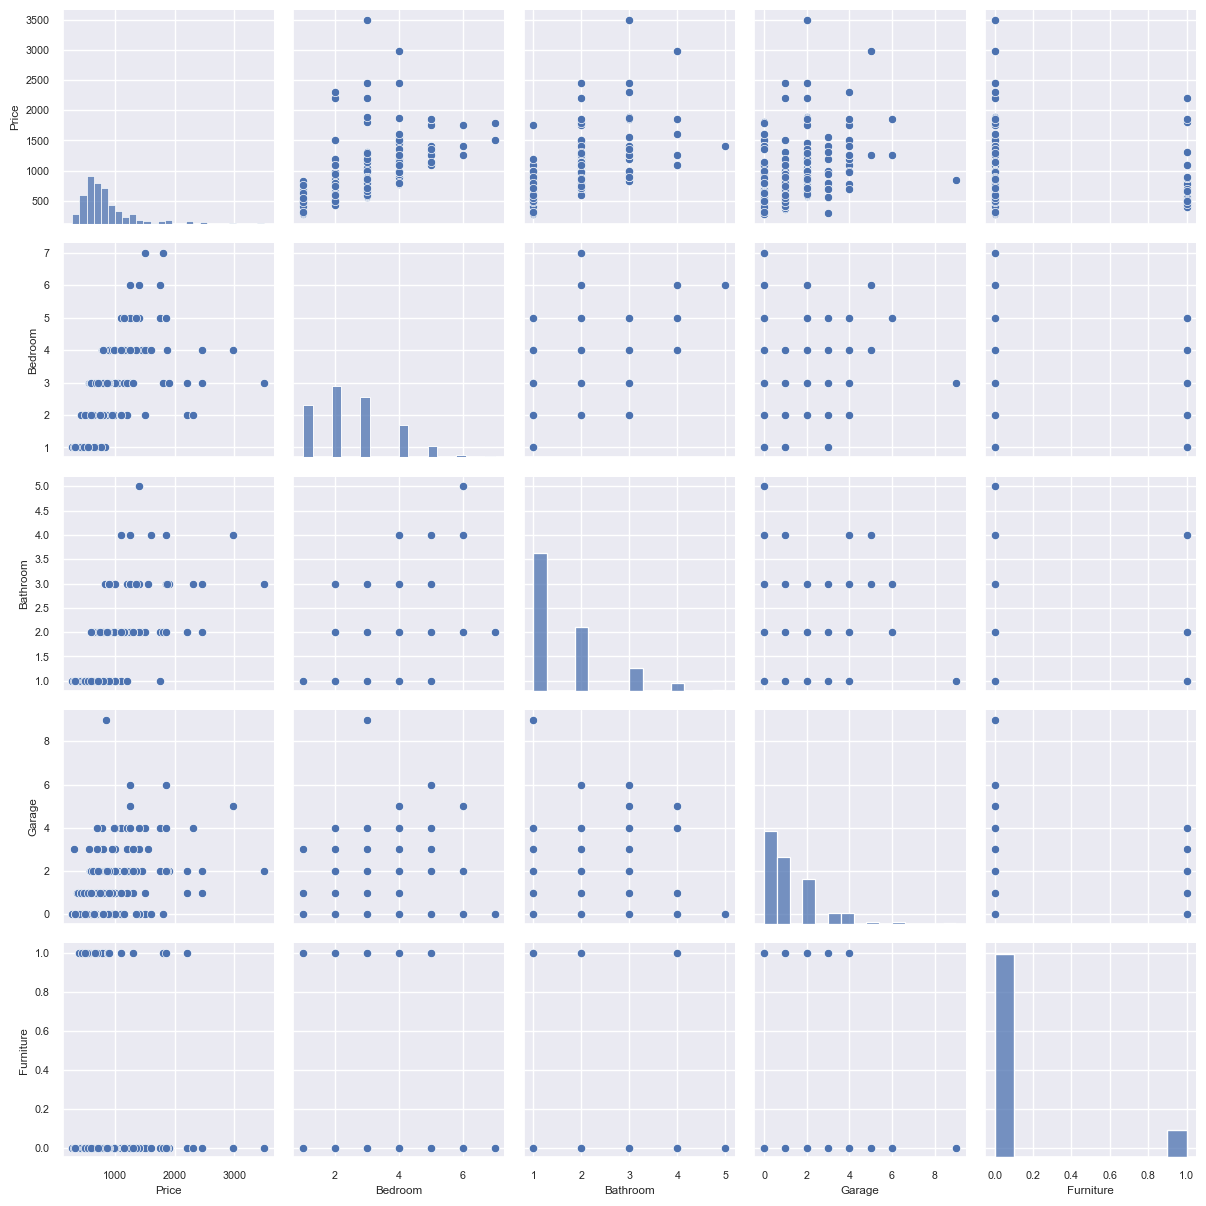

In [174]:
sns.pairplot(data[['Price', 'Bedroom', 'Bathroom','Garage','Furniture']], diag_kind='hist')

In [175]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Suburb,292.0,15.174658,12.538339,0.0,1.0,15.5,25.0,43.0
Price,292.0,829.119863,431.220082,280.0,550.0,717.5,950.0,3500.0
Bedroom,292.0,2.534247,1.238913,1.0,2.0,2.0,3.0,7.0
Bathroom,292.0,1.571918,0.815422,1.0,1.0,1.0,2.0,5.0
Garage,292.0,1.133562,1.326172,0.0,0.0,1.0,2.0,9.0
Furniture,292.0,0.119863,0.325359,0.0,0.0,0.0,0.0,1.0
Type_Apartment,292.0,0.342466,0.475349,0.0,0.0,0.0,1.0,1.0
Type_House,292.0,0.414384,0.493461,0.0,0.0,0.0,1.0,1.0
Type_Studio,292.0,0.003425,0.058521,0.0,0.0,0.0,0.0,1.0
Type_Townhouse,292.0,0.113014,0.317153,0.0,0.0,0.0,0.0,1.0


### Outliers
How to difine an outlier in this data set is and interesting problem. Below you can see that there is no datapoint that is  an outlier on all metrics. DBSCAN and Mahalanobis Distance would be good metrics here.

Considering the small scope of the data it seems like it would make sense to remove any outliers. Note that we can not tell whether or not these outliers are outliers in the problem domain as our data does not come close to capturing the whole domain.

Initialy will leave the outliers in and then remove them. We will assume that removing them will make the model more accurate on this data. However as we dont know if these are outliers in the problem domain and as such it may actually make sense to keep them in, its hard to say.

In [176]:
data.sort_values(by='Price', ascending=False).head(3)

,Suburb,Price,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
235,28,3500.0,3,3.0,2.0,0,0,1,0,0,0
266,32,2980.0,4,4.0,5.0,0,0,1,0,0,0
117,11,2450.0,4,2.0,2.0,0,0,1,0,0,0


In [177]:
data.sort_values(by='Bedroom', ascending=False).head(3)

,Suburb,Price,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
135,12,1795.0,7,2.0,0.0,0,0,1,0,0,0
128,11,1500.0,7,2.0,0.0,0,0,1,0,0,0
126,11,1750.0,6,2.0,2.0,0,0,1,0,0,0


In [178]:
data.sort_values(by='Bathroom', ascending=False).head(3)

,Suburb,Price,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
143,13,1400.0,6,5.0,0.0,0,0,1,0,0,0
201,22,1100.0,4,4.0,0.0,0,0,1,0,0,0
111,10,1100.0,4,4.0,1.0,0,0,1,0,0,0


In [179]:
data.sort_values(by='Garage', ascending=False).head(3)

,Suburb,Price,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
210,23,850.0,3,1.0,9.0,0,0,1,0,0,0
93,5,1850.0,5,3.0,6.0,0,0,1,0,0,0
260,32,1250.0,5,2.0,6.0,0,0,1,0,0,0


## Covariance

In [180]:
scaler = MinMaxScaler()

# Separate features and target
X = data.drop('Price', axis=1)  # Features
y = data['Price']  # Target

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

X_normalized_array = scaler_features.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized_array, columns=X.columns)

scaler_target = MinMaxScaler()

y_normalized_array = scaler_target.fit_transform(y.values.reshape(-1, 1))
y_normalized = y_normalized_array.flatten()
y_normalized_series = pd.Series(y_normalized, index=X_normalized.index, name='Price')

df_normalized = pd.concat([X_normalized, y_normalized_series], axis=1)

In [181]:
covariance_matrix = df_normalized.cov()
covariance_matrix

,Suburb,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit,Price
Suburb,0.085024,0.013822,0.011185,0.008775,-0.024144,-0.060934,0.038589,0.001025,0.010648,0.010672,0.007207
Bedroom,0.013822,0.042636,0.026744,0.014711,-0.010137,-0.048926,0.054041,-0.000879,0.011094,-0.015331,0.017337
Bathroom,0.011185,0.026744,0.041557,0.010280,-0.008606,-0.026797,0.031613,-0.000491,0.011277,-0.015602,0.017745
Garage,0.008775,0.014711,0.010280,0.021713,-0.006749,-0.025336,0.026666,-0.000433,0.002517,-0.003414,0.008248
Furniture,-0.024144,-0.010137,-0.008606,-0.006749,0.105858,0.048157,-0.029221,-0.000412,-0.010156,-0.008367,-0.001570
Type_Apartment,-0.060934,-0.048926,-0.026797,-0.025336,0.048157,0.225957,-0.142400,-0.001177,-0.038836,-0.043544,-0.014273
Type_House,0.038589,0.054041,0.031613,0.026666,-0.029221,-0.142400,0.243504,-0.001424,-0.046992,-0.052688,0.023224
Type_Studio,0.001025,-0.000879,-0.000491,-0.000433,-0.000412,-0.001177,-0.001424,0.003425,-0.000388,-0.000435,-0.000405
Type_Townhouse,0.010648,0.011094,0.011277,0.002517,-0.010156,-0.038836,-0.046992,-0.000388,0.100586,-0.014369,0.002128
Type_Unit,0.010672,-0.015331,-0.015602,-0.003414,-0.008367,-0.043544,-0.052688,-0.000435,-0.014369,0.111037,-0.010675


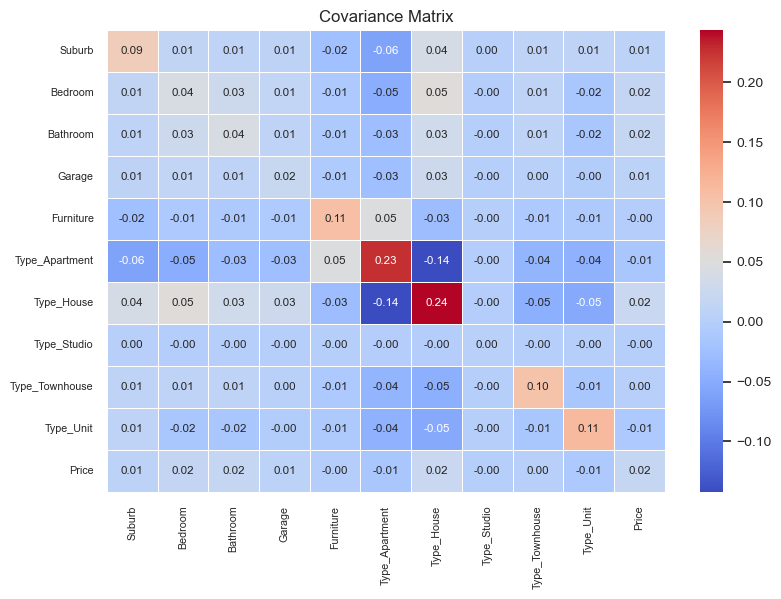

In [182]:
sns.set(font_scale=0.7)

f, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(covariance_matrix, annot=True, fmt=".2f", linewidths=.5, ax=ax, cmap='coolwarm')

title_fontsize = 12  # for example

ax.set_title('Covariance Matrix', fontsize=title_fontsize)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10) 
plt.show()

# Model testing and evaluation

In [183]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [184]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_test_denormalized, predictions, figure_size=(10, 6)):
    # Create a new figure and an axes object for the subplot.
    plt.figure(figsize=figure_size)

    # Scatter plot for actual and predicted values
    plt.scatter(y_test_denormalized, predictions, color='blue', label='Data points')

    # Plot a line for perfect predictions
    min_val = min(min(y_test_denormalized), min(predictions))
    max_val = max(max(y_test_denormalized), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Perfect predictions')

    # Titles and labels
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Legend
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()


In [185]:
def train_and_tune(data, target, model, param_grid):

    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)

    # do the search
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best model
    best = grid_search.best_estimator_

    # Predict and evaluate
    y_pred = best.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
#     print(model)
#     print(f"Root Mean Squared Error of Best Model: {np.sqrt(mse)}")
#     print(f'Mean Absolute Error: {mae}')
    r2 = r2_score(y_test, y_pred)
#     print(f'R-squared: {r2}')
#     print('')
    
    return {'model': best, 'rmse': np.sqrt(mse), 'r2': r2,'mae':mae , 'best_params': best.get_params()}

In [186]:
X = df_normalized.drop('Price', axis=1)
Y = df_normalized['Price']

# X = df_data.drop('Price', axis=1)
# Y = df_data['Price']

# Initialize models
lm = LinearRegression()
svr = SVR()
elastic_net = ElasticNet()
lasso = Lasso()
ridge = Ridge()
decision_tree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()

# Models in a list for easy access or iteration
models = [lm, svr, elastic_net, lasso, ridge, decision_tree, random_forest, gradient_boosting]

linear_params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}
ridge_param_grid = {
    'alpha': [1e-2, 1e-1, 1, 10, 100]
}
random_forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None]
}
gradient_boosting_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}
svr_param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
elastic_net_param_grid = {
    'alpha': [0.1, 1, 10],  
    'l1_ratio': [0.2, 0.5, 0.8]
}
lasso_param_grid = {
    'alpha': [0.1, 1, 10],
}
decision_tree_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

params = [linear_params, svr_param_grid, elastic_net_param_grid, lasso_param_grid, ridge_param_grid, 
          decision_tree_param_grid, random_forest_param_grid, random_forest_param_grid, gradient_boosting_param_grid]

In [187]:
results = []

for i in range(len(models)):
    result =  train_and_tune(X, Y, models[i], params[i])
    results.append(result)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


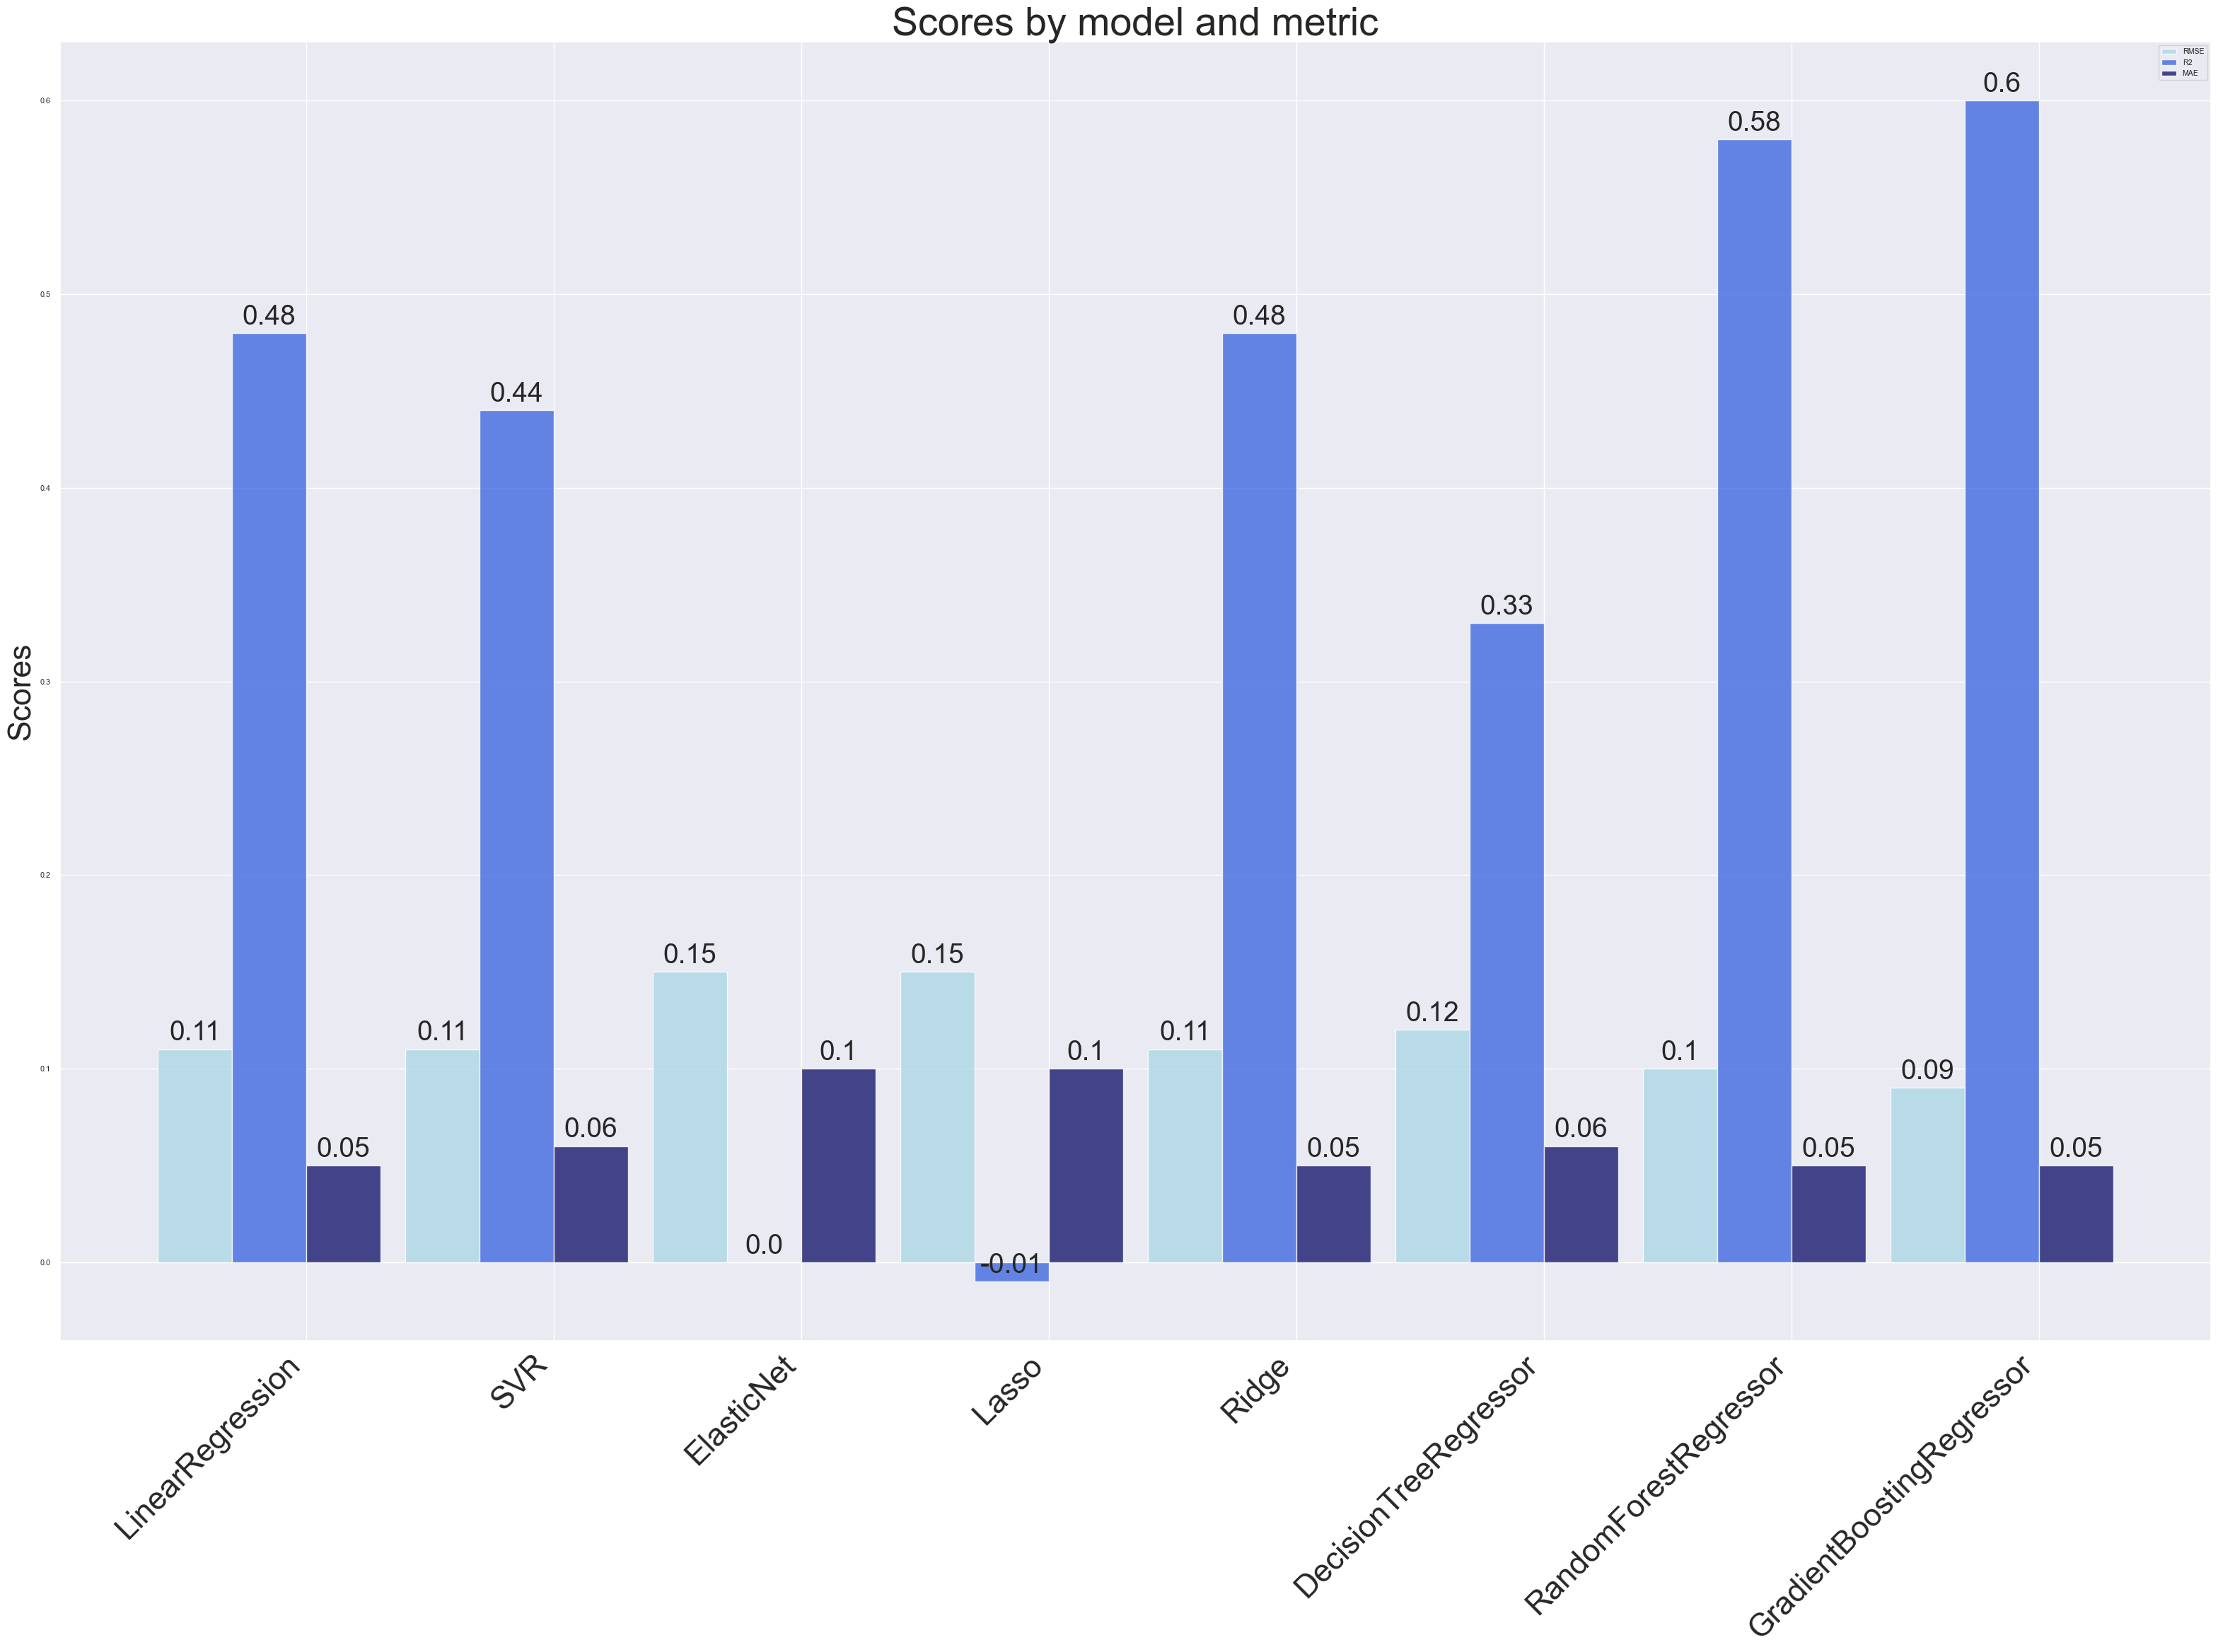

In [188]:
model_names = [x['model'].__class__.__name__ for x in results]

rmse_values = [round(x['rmse'], 2) for x in results]
r2_values = [round(x['r2'], 2) for x in results]
mae_values = [round(x['mae'], 2) for x in results]

x = np.arange(len(model_names))  # the label locations
num_models = len(model_names)
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(num_models * 4, 24))
x = np.arange(len(model_names))

plt.rcParams.update({'font.size': 28})

colors = ['lightblue', 'royalblue', 'midnightblue']
rects1 = ax.bar(x - width, rmse_values, width, label='RMSE', color=colors[0], alpha=0.8)
rects2 = ax.bar(x, r2_values, width, label='R2', color=colors[1], alpha=0.8)
rects3 = ax.bar(x + width, mae_values, width, label='MAE', color=colors[2], alpha=0.8)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores', fontsize=32)
ax.set_title('Scores by model and metric', fontsize=40)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=32, rotation=45, ha="right")
ax.legend()

# Show values on bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

ax.set_xticks(x + width / 2)
ax.set_xticklabels(model_names)

fig.tight_layout()

plt.show()

From the above graph we can see the best model performances based on the hyperpareamters we passed.

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

model = RandomForestRegressor(**results[6]['best_params'])#ramndom forets hyperparams
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='log2')

R-squared: 0.5965493850417292
Mean Absolute Error: 154.0428088453886


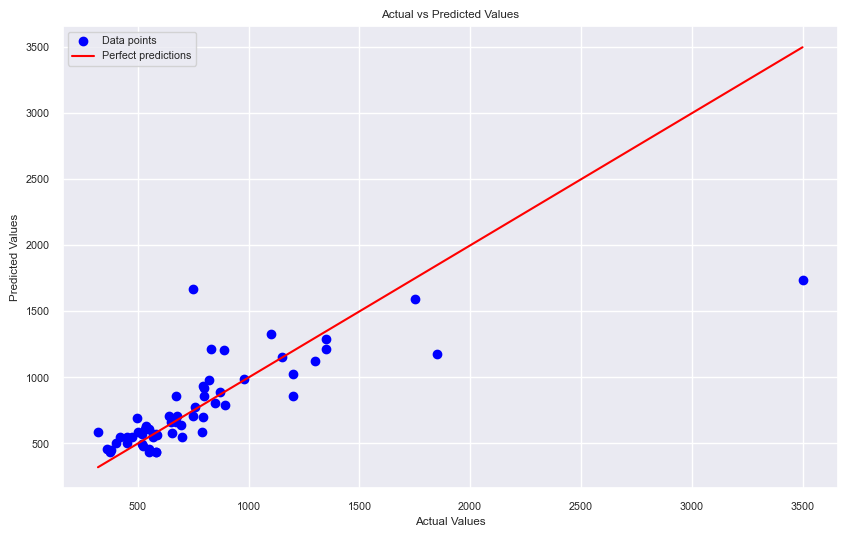

In [190]:
predictions = model.predict(X_test)

#un normalise
predictions = predictions.reshape(-1, 1)
predictions = scaler_target.inverse_transform(predictions)
predictions = predictions.flatten()

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_denormalized = scaler_target.inverse_transform(y_test_reshaped)
y_test_denormalized = y_test_denormalized.flatten()
y_test_denormalized_series = pd.Series(y_test_denormalized, index=y_test.index)

r2 = r2_score(y_test_denormalized, predictions)
print(f'R-squared: {r2}')

mae = mean_absolute_error(y_test_denormalized, predictions)
print(f'Mean Absolute Error: {mae}')

plot_actual_vs_predicted(y_test_denormalized, predictions)

From this graph of predicted vs actual values we can see the the model does not predict higher prices that well but perfroms resonably on the highest concentration of the data. This is likely just an artifact of limited data. If we had more dadat points to populate those higher ranges we would be able to do a proper evaluation.

In [191]:
errors = np.abs(predictions - y_test_denormalized_series)
errors.reset_index(drop=True, inplace=True)

sorted_errors = errors.sort_values(ascending=False)
top_5_indices = sorted_errors.head(5).index
print(y_test_denormalized_series.loc[top_5_indices])
X_test.loc[top_5_indices]

18    3500.0
52     750.0
22    1850.0
33     830.0
9     1200.0
dtype: float64


,Suburb,Bedroom,Bathroom,Garage,Furniture,Type_Apartment,Type_House,Type_Studio,Type_Townhouse,Type_Unit
18,0.651163,0.333333,0.50,0.222222,0.0,0.0,1.0,0.0,0.0,0.0
52,0.000000,0.166667,0.25,0.111111,0.0,1.0,0.0,0.0,0.0,0.0
22,0.837209,0.666667,0.25,0.222222,0.0,0.0,1.0,0.0,0.0,0.0
33,0.255814,0.166667,0.50,0.111111,0.0,1.0,0.0,0.0,0.0,0.0
9,0.116279,0.166667,0.25,0.222222,0.0,1.0,0.0,0.0,0.0,0.0


### Removing outliers
As you will see below, after using DBSCAN to remove oulies we get a slighlty better prediction. With this new prediction we see that perhaps we should just treat the higher prices as outlers and caviat our model to predict up to a certain range.

both DBSCAN and Mahalanobis Distance chose similar outliers.

In [192]:
features = df_normalized.drop(columns=['Price'])
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(features)

cluster_series = pd.Series(clusters, index=data.index, name='cluster')

# Identify outliers
outliers = cluster_series[cluster_series == -1]
# outliers
df_without_outliers = df_normalized.drop(index=outliers.index -1)

R-squared: 0.6120469574110897
Mean Absolute Error: 130.50460267097347


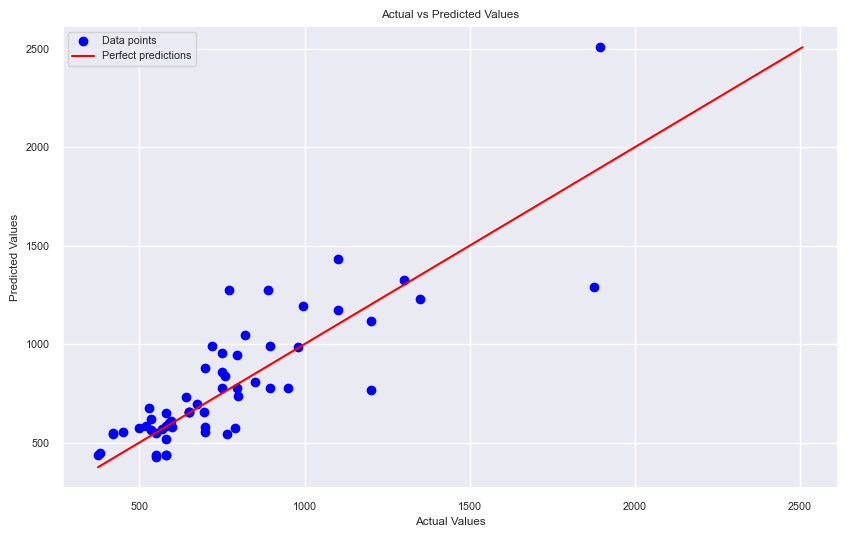

In [193]:
# Train model
X_no_out = df_without_top_5_outliers.drop('Price', axis=1)
Y_no_out = df_without_top_5_outliers['Price']

X_train, X_test, y_train, y_test = train_test_split(X_no_out, Y_no_out, test_size=0.2, random_state=42)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

model = RandomForestRegressor(**results[6]['best_params'])#ramndom forets hyperparams
model.fit(X_train, y_train)

#predictions
predictions = model.predict(X_test)

#un normalise
predictions = predictions.reshape(-1, 1)
predictions = scaler_target.inverse_transform(predictions)
predictions = predictions.flatten()

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_denormalized = scaler_target.inverse_transform(y_test_reshaped)
y_test_denormalized = y_test_denormalized.flatten()
y_test_denormalized_series = pd.Series(y_test_denormalized, index=y_test.index)

r2 = r2_score(y_test_denormalized, predictions)
print(f'R-squared: {r2}')

mae = mean_absolute_error(y_test_denormalized, predictions)
print(f'Mean Absolute Error: {mae}')

plot_actual_vs_predicted(y_test_denormalized, predictions)

# Feature selection
The plots below give us an idea about how the model is making its predictions.

All the features seem to give some impact on the model. Intestingly Bathrooms has a higher impact than Bedrooms. 

Studio has no impact on the  model, this is potentially because there is only 1 stuido entry. In a more complete dataset we may see a non-zero value. Therefore we cannot say whether or not studio is likely to have an impact in this domain.

Analysing the dependiency plots:
- Suburb: We can see some variance however we need a bit more context to really dive deeper here.
- Bathroom: We see a very nice consistant trend here
- Bedroom: A trend but not so tight
- Garage: Intesting thing happening here, we have spike and a dip at 2 and 3 repectively. Something to investigate further.
- Furniture: Furnished homes puth the prediction up as we would expect and unfurnished has a small effect on the model. this      seems intuitvely correct
- Type: Nothing too crazy accross all of these, appartment has the highest impact on the model and is positive so it increases the prediction value which is interesting.

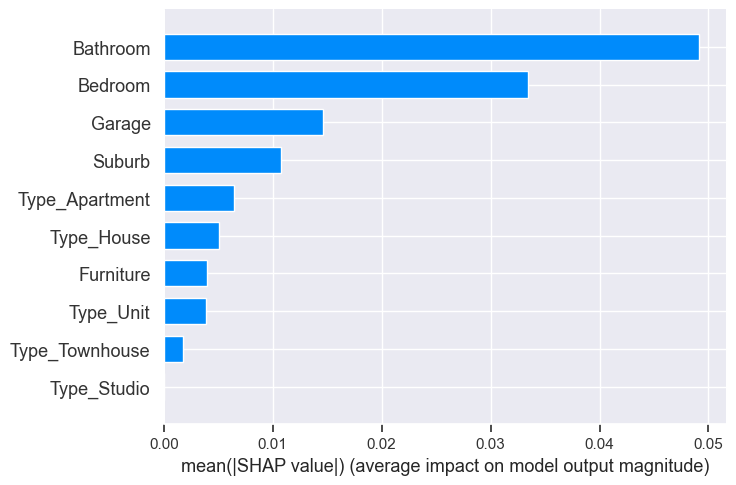

In [194]:
explainer = shap.TreeExplainer(model, X_train)

shap_values = explainer.shap_values(X_train, check_additivity=False)

shap.summary_plot(shap_values, X_train, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


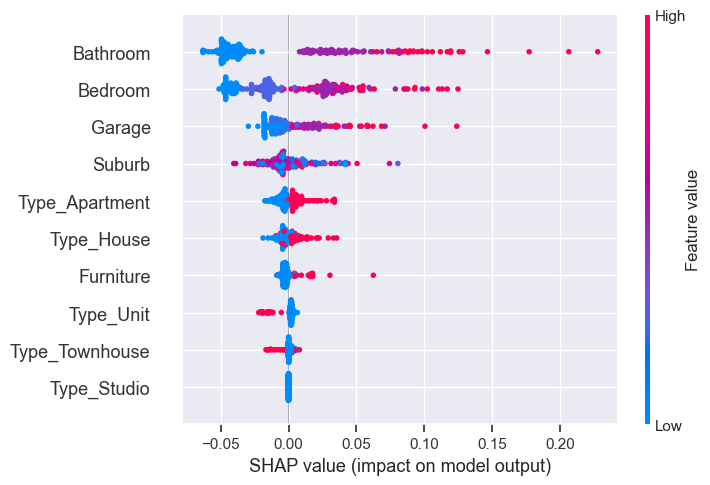

In [195]:
shap.summary_plot(shap_values, X_train)

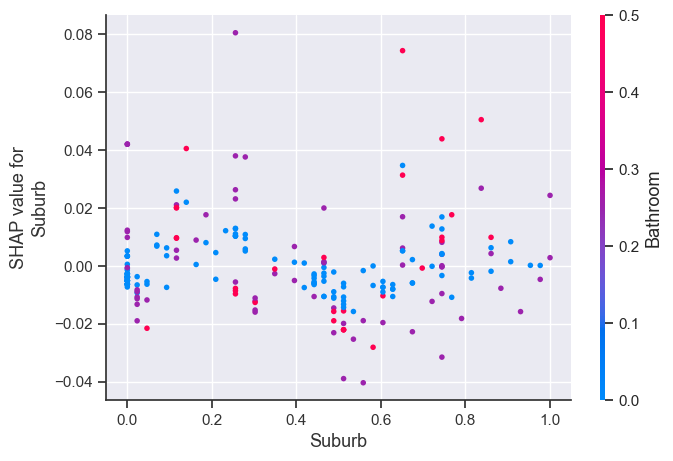

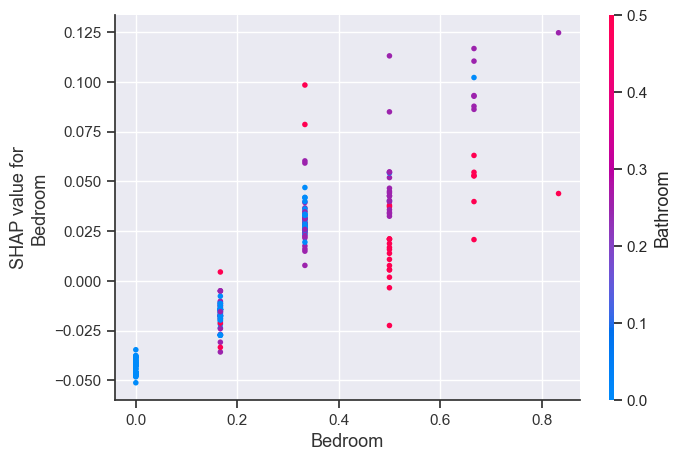

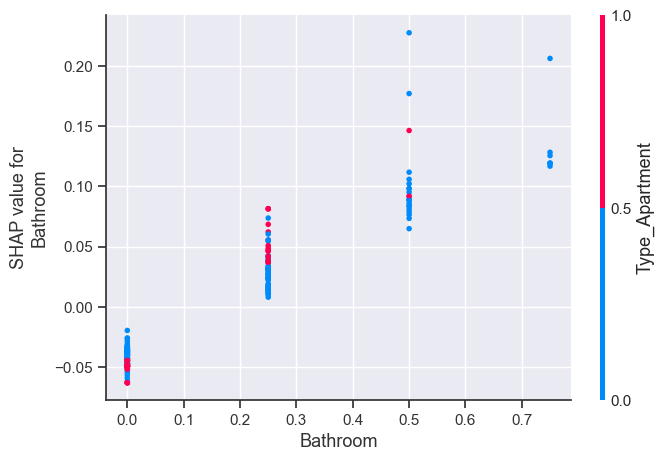

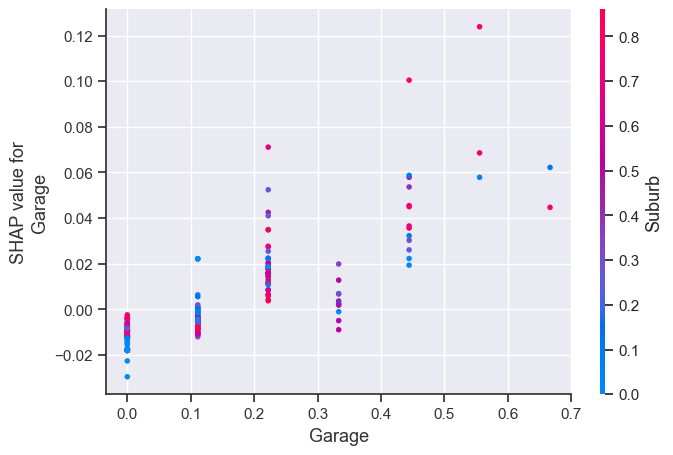

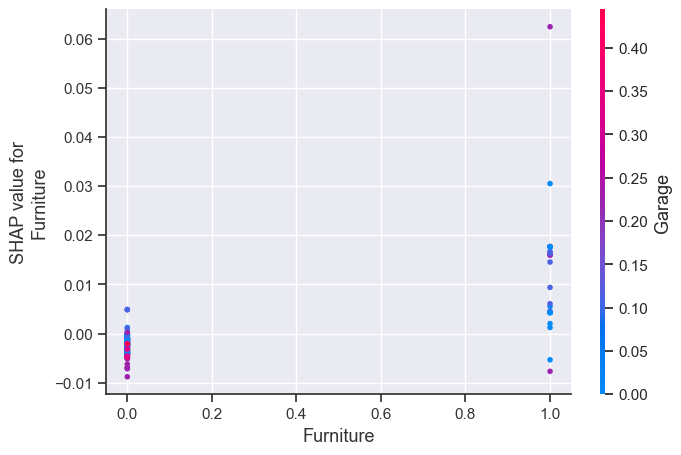

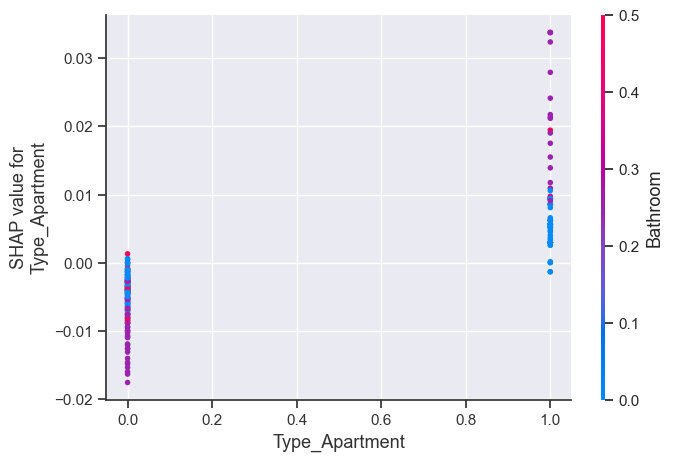

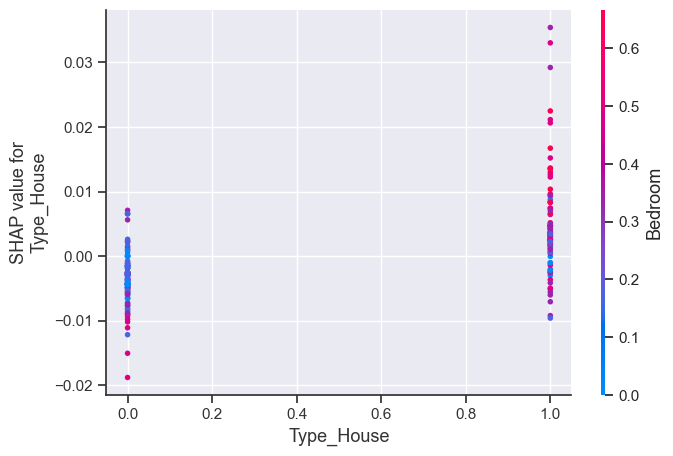

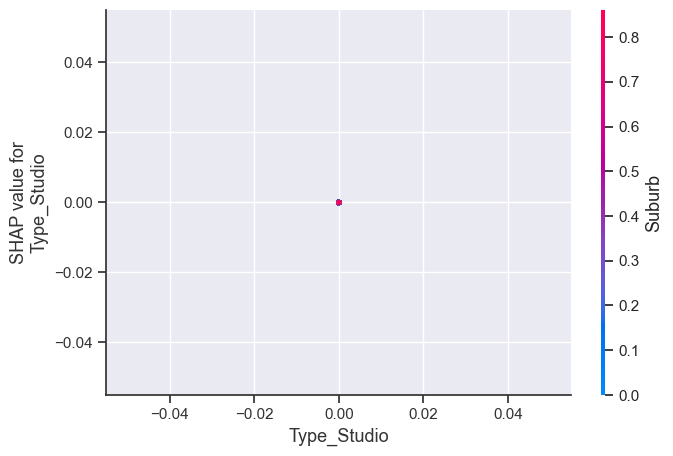

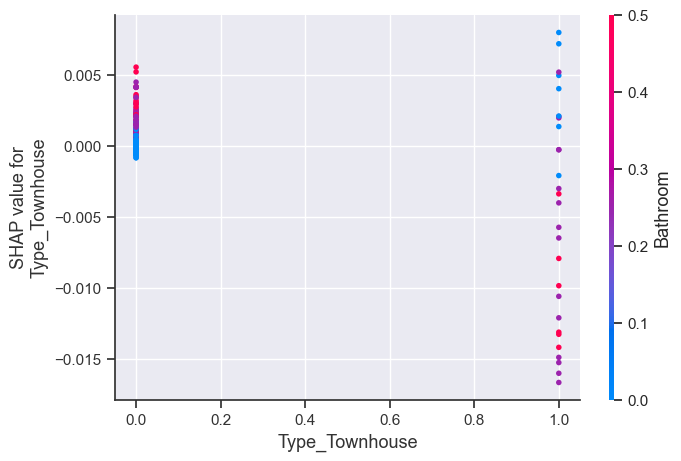

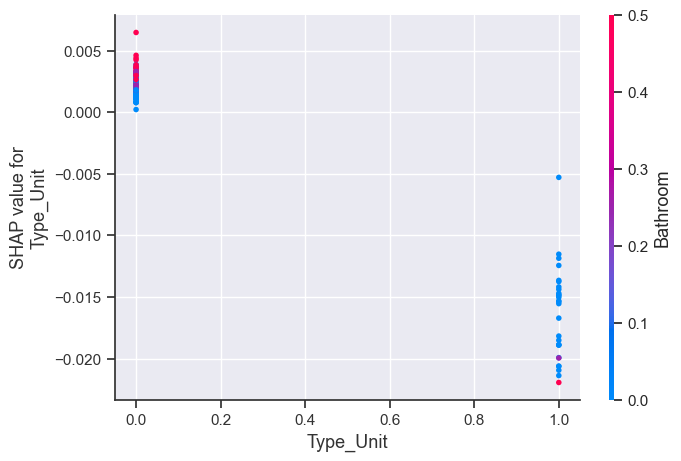

In [196]:
for feat in X_train.columns:
    shap.dependence_plot(feat, shap_values, X_train)

# Investigatign deep learning

In [197]:
# X = df_normalized.drop('Price', axis=1)
# Y = df_normalized['Price']

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [198]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                 activation='relu',
                                 input_shape=(X_train.shape[1],)))

    # Adding dropout layer to prevent overfitting
    model.add(keras.layers.Dropout(rate=hp.Float(
        'dropout_1',
        min_value=0.0,
        max_value=0.5,
        default=0.25,
        step=0.05,
    )))

    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                     activation='relu'))
        model.add(keras.layers.Dropout(rate=hp.Float(
            'dropout_1',
            min_value=0.0,
            max_value=0.5,
            default=0.25,
            step=0.05,
        )))

    model.add(keras.layers.Dense(1))  # Output layer

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])

    return model

# Initialize the random search
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,  # number of model configurations to test
    executions_per_trial=3,  # number of trials per configuration
    directory='project',
    project_name='House Price Prediction')

# Display search space summary
tuner.search_space_summary()

# Run the hyperparameter search
tuner.search(X_train, y_train,
             epochs=5,  # number of epochs for each model/trial
             validation_split=0.2)  # data split for validation

# Get the best model with its parameters
best_model = tuner.get_best_models(num_models=1)[0]

# Show a summary of the best model
best_model.summary()

Reloading Tuner from project\House Price Prediction\tuner0.json
Search space summary
Default search space size: 9
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_valu

2/2 [==============================] - 0s 2ms/step
R-squared: 0.617525134254481
Mean Absolute Error: 119.8287090433055


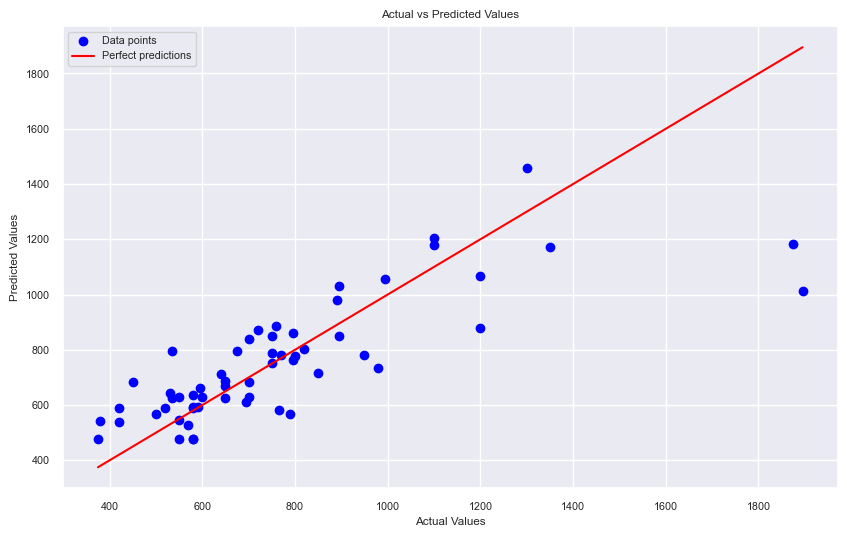

In [199]:
predictions = best_model.predict(X_test)

#un normalise
predictions = predictions.reshape(-1, 1)
predictions = scaler_target.inverse_transform(predictions)
predictions = predictions.flatten()

y_test_reshaped = y_test.values.reshape(-1, 1)
y_test_denormalized = scaler_target.inverse_transform(y_test_reshaped)
y_test_denormalized = y_test_denormalized.flatten()
y_test_denormalized_series = pd.Series(y_test_denormalized, index=y_test.index)

r2 = r2_score(y_test_denormalized, predictions)
print(f'R-squared: {r2}')

mae = mean_absolute_error(y_test_denormalized, predictions)
print(f'Mean Absolute Error: {mae}')

plot_actual_vs_predicted(y_test_denormalized, predictions)

The deep learning model seems to give btter results than the other models. Again it seems to struggle with the higher price prediction even with the main noutliers removed.

It looks like these higher priced points may be higher for a reason that our data does not capture. So The conclusion is to say that this model only predicts for proces up to $1400 per week.

# Additional data for the app
Some additional statistics the user may or may not find usefull. This data is used and displayed in the app.

In [201]:
A_Sale = pd.read_csv("data/Average Sale Price.csv")
A_Rent = pd.read_csv("data/Average weekly rent.csv")
P_Num = pd.read_csv("data/Number of rental properties.csv")
S_Vol = pd.read_csv("data/Sales volume.csv")

A_Sale = A_Sale.replace('-', 0)
A_Sale['Focus Area'] = A_Sale['Focus Area'] + '_average_sale_price'


A_Rent = A_Rent.rename(columns={'Number of Bedrooms': 'Focus Area'})
A_Rent = A_Rent[~A_Rent['Focus Area'].str.contains('Total', case=False)]
A_Rent['Focus Area'] = A_Rent['Focus Area'] + '_average_weekly_rent'


P_Num = P_Num.rename(columns={'Number of Bedroom': 'Focus Area'})
P_Num = P_Num[~P_Num['Focus Area'].str.contains('Total', case=False)]
P_Num['Focus Area'] = P_Num['Focus Area'] + '_total_property'


S_Vol = S_Vol.replace('-', 0)
S_Vol = S_Vol[~S_Vol['Focus Area'].str.contains('Total', case=False)]
S_Vol['Focus Area'] = S_Vol['Focus Area'] + '_sale_vol'

results = pd.concat([A_Sale, A_Rent, P_Num, S_Vol])
results = results.fillna(0)
results.to_csv('area_data.csv', index=False)
results.head()

,Focus Area,0,1,2,3,4,5+
0,Central Auckland_average_sale_price,0,"$242,715","$509,706","$710,000","$1,648,000",0
1,Central Auckland East_average_sale_price,"$1,873,900",0,"$796,188","$1,242,833","$1,354,231","$2,195,000"
2,Central Auckland West_average_sale_price,0,"$785,000","$1,042,667","$1,483,000","$1,220,000","$2,650,000"
3,Eastern Suburbs_average_sale_price,0,"$455,833","$975,800","$1,262,200","$1,602,417","$1,830,000"
4,Franklin/Manukau Rural_average_sale_price,"$1,022,321",0,"$567,200","$846,696","$1,365,425","$1,236,643"


# Using AWS
We can use aws to help perform hyperparameter tuning on our data. This is how you would do it with a Xgboost model. Last time I used the lab for A2 I was charged like $60. How I was supposed to pay it remains a mystery, they just sent a bill. I mostly cleared this up with the support after a bit of back and forward, apparently I still owe them 52c. So for safety I am not actually going to run this but the proccess is straitforward.

Based on the resutls from the last assignment and doing the labs it is also very unlikely that the tuning from AWS will perform significantly or even slighlty better that our own tuning. The advantage of using AWS is that you can set up a pipeline and run multiple jobs, this isnt relavent here.

You could also host this on AWS but I dont want another bill. Honestly even the wierd charging thing aside I think AWS is a very sub-optimal tool for projects like this. I could only see it being usefull for large scale applications where it is perhaps more cost effective to use their servers. Leveraging any of there features on a small scale seems a bit more trouble than it is worth.

In [169]:
import pandas as pd
import boto3
from pathlib import Path
import sagemaker
from sagemaker.pytorch import PyTorch
import sys

from sklearn.model_selection import train_test_split
import os
import warnings, requests, zipfile, io
from sagemaker.image_uris import retrieve
# import config

IAM_ROLE = sagemaker.get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
DEFAULT_BUCKET = sess.default_bucket()

s3 = boto3.client('s3')

bucket = 'mynlpdata'
data_key = 'A3/prediction.csv'

s3.download_file(bucket, summaries_key, summaries_file_name)

data = pd.read_csv('prediction.csv')

data.to_csv("prediction.csv", index=False)

file_name = "prediction.csv"
object_name = "A3/train.csv"
s3.upload_file(file_name, bucket, object_name)

data.head()

ModuleNotFoundError: No module named 'sagemaker'

In [ ]:
train, test_and_validate = train_test_split(data, test_size=0.2, random_state=42)
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42)

prefix='A3'

train_file='data_train.csv'
test_file='data_test.csv'
validate_file='data_validate.csv'

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [ ]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

#make sure we are in regression mode
hyperparams = {
        "num_round": "42",
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "silent": 1
    }

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

xgb_model.fit(inputs=data_channels, logs=False)

batch_X = test.iloc[:,1:];

batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

In [ ]:
# getting some model stats for reference later 

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix, 'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['predictions'])

# True labels
test_labels = test.iloc[:, 0]

# Regression metrics
mae = mean_absolute_error(test_labels, target_predicted['predictions'])
mse = mean_squared_error(test_labels, target_predicted['predictions'])
r2 = r2_score(test_labels, target_predicted['predictions'])

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

In [ ]:
#run a hyperparameter tuning job

# %%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1,
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


#make sure I am in regression
xgb.set_hyperparameters(eval_metric='rmse',
                        objective='reg:squarederror',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:rmse' #regression :)
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})